# Testing
### Median-Vermögen steuerpflichtiger natürlicher Personen nach Jahr, Steuertarif und Stadtquartier.


Datum: 03.02.2022

**Importiere die notwendigen Packages**

In [ ]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly

In [3]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
#from datetime import datetime
import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns


Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [4]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

Importiere einen Datensatz von der **DWH_INT** Dropzone.

- Beachte dabei die Notation des Pfades...
- Definiere mal aktuell noch keine weiteren Parameter beim Import

**Dataset auf INTEG Datenkatalog**: https://data.integ.stadt-zuerich.ch/dataset/int_dwh_fd_median_vermoegen_quartier_od1004


In [5]:
# Filepath
fp = r"//szh.loc/ssz/applikationen/OGD_Dropzone/INT_DWH/fd_median_vermoegen_quartier_OD1004/WIR100OD1004.csv "

# Read the data
data2betested = pd.read_csv(
    fp, 
    sep=',',
   #usecols=[0,1,2,3,4,6],
   #names=['stationid','year','month','avgtemp','latitude','longitude','elevation','station','countryid','country'],
   #skiprows=1,
    parse_dates=['SteuerJahr'],
    #date_parser=lambda x: pd.to_datetime(x, format="%Y"), 
    #index_col="date_time",
    low_memory=False    
    )
print("done")

done


In der Folge ein paar erste Tests:

In [6]:
type(data2betested)

pandas.core.frame.DataFrame

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [7]:
data2betested

,SteuerJahr,QuarSort,QuarLang,SteuerTarifSort,SteuerTarifLang,SteuerVermoegen_p50,SteuerVermoegen_p25,SteuerVermoegen_p75
0,1999-01-01,11,Rathaus,0,Grundtarif,20,0,150
1,1999-01-01,11,Rathaus,1,Verheiratetentarif,191,30,792
2,1999-01-01,11,Rathaus,2,Einelternfamilientarif,23,0,406
3,1999-01-01,12,Hochschulen,0,Grundtarif,28,0,186
4,1999-01-01,12,Hochschulen,1,Verheiratetentarif,249,37,724
...,...,...,...,...,...,...,...,...
2137,2019-01-01,122,Schwamendingen-Mitte,1,Verheiratetentarif,39,0,247
2138,2019-01-01,122,Schwamendingen-Mitte,2,Einelternfamilientarif,0,0,13
2139,2019-01-01,123,Hirzenbach,0,Grundtarif,13,0,71
2140,2019-01-01,123,Hirzenbach,1,Verheiratetentarif,38,0,172


In [8]:
data2betested.dtypes

SteuerJahr             datetime64[ns]
QuarSort                        int64
QuarLang                       object
SteuerTarifSort                 int64
SteuerTarifLang                object
SteuerVermoegen_p50           float64
SteuerVermoegen_p25           float64
SteuerVermoegen_p75           float64
dtype: object

In [9]:
data2betested.shape

(2142, 8)

Beschreibe einzelne Attribute

In [10]:
data2betested.describe()

,QuarSort,SteuerTarifSort,SteuerVermoegen_p50,SteuerVermoegen_p25,SteuerVermoegen_p75
count,2142,2142,2081,2081,2081
mean,65,1,86,14,332
std,36,1,124,31,405
min,11,0,0,0,7
25%,33,0,16,0,95
50%,67,1,40,1,191
75%,92,2,85,9,363
max,123,2,875,220,2629


Wie viele Nullwerte gibt es im Datensatz?

In [11]:
data2betested.isnull().sum()

SteuerJahr              0
QuarSort                0
QuarLang                0
SteuerTarifSort         0
SteuerTarifLang         0
SteuerVermoegen_p50    61
SteuerVermoegen_p25    61
SteuerVermoegen_p75    61
dtype: int64

In [26]:
#check sollte leer sein. 
check = data2betested.query('SteuerVermoegen_p50.isnull() and SteuerTarifLang != "Einelternfamilientarif"')
check

,SteuerJahr,QuarSort,QuarLang,SteuerTarifSort,SteuerTarifLang,SteuerVermoegen_p50,SteuerVermoegen_p25,SteuerVermoegen_p75


Wandle die Spalte Jahr von Int zu **Datetime** um. Dies wird in den meisten Grafiken so benötigt.

In [12]:
data2betested['SteuerJahr']=pd.to_datetime(data2betested['SteuerJahr'], format='%Y')

#TO DO --> setze das Datum auf den 31.12. der Jahres.
#test=data2betested[['StichtagDatJahr']].date().replace(month=12, day=31)

data2betested

,SteuerJahr,QuarSort,QuarLang,SteuerTarifSort,SteuerTarifLang,SteuerVermoegen_p50,SteuerVermoegen_p25,SteuerVermoegen_p75
0,1999-01-01,11,Rathaus,0,Grundtarif,20,0,150
1,1999-01-01,11,Rathaus,1,Verheiratetentarif,191,30,792
2,1999-01-01,11,Rathaus,2,Einelternfamilientarif,23,0,406
3,1999-01-01,12,Hochschulen,0,Grundtarif,28,0,186
4,1999-01-01,12,Hochschulen,1,Verheiratetentarif,249,37,724
...,...,...,...,...,...,...,...,...
2137,2019-01-01,122,Schwamendingen-Mitte,1,Verheiratetentarif,39,0,247
2138,2019-01-01,122,Schwamendingen-Mitte,2,Einelternfamilientarif,0,0,13
2139,2019-01-01,123,Hirzenbach,0,Grundtarif,13,0,71
2140,2019-01-01,123,Hirzenbach,1,Verheiratetentarif,38,0,172


Bereite die Daten für die Grafik unten vor

In [13]:
Jahre = data2betested.groupby("SteuerJahr")
len(Jahre)

21

In [14]:
for key, group in Jahre:
    print(key, len(group))

1999-01-01 00:00:00 102
2000-01-01 00:00:00 102
2001-01-01 00:00:00 102
2002-01-01 00:00:00 102
2003-01-01 00:00:00 102
2004-01-01 00:00:00 102
2005-01-01 00:00:00 102
2006-01-01 00:00:00 102
2007-01-01 00:00:00 102
2008-01-01 00:00:00 102
2009-01-01 00:00:00 102
2010-01-01 00:00:00 102
2011-01-01 00:00:00 102
2012-01-01 00:00:00 102
2013-01-01 00:00:00 102
2014-01-01 00:00:00 102
2015-01-01 00:00:00 102
2016-01-01 00:00:00 102
2017-01-01 00:00:00 102
2018-01-01 00:00:00 102
2019-01-01 00:00:00 102


In [15]:
myJahr = "2018-01-01"
aktuellesJahr=Jahre.get_group(myJahr)   
aktuellesJahr

,SteuerJahr,QuarSort,QuarLang,SteuerTarifSort,SteuerTarifLang,SteuerVermoegen_p50,SteuerVermoegen_p25,SteuerVermoegen_p75
1938,2018-01-01,11,Rathaus,0,Grundtarif,48,2,290
1939,2018-01-01,11,Rathaus,1,Verheiratetentarif,404,81,1564
1940,2018-01-01,11,Rathaus,2,Einelternfamilientarif,80,2,532
1941,2018-01-01,12,Hochschulen,0,Grundtarif,55,5,311
1942,2018-01-01,12,Hochschulen,1,Verheiratetentarif,567,188,1978
...,...,...,...,...,...,...,...,...
2035,2018-01-01,122,Schwamendingen-Mitte,1,Verheiratetentarif,36,0,225
2036,2018-01-01,122,Schwamendingen-Mitte,2,Einelternfamilientarif,0,0,21
2037,2018-01-01,123,Hirzenbach,0,Grundtarif,12,0,69
2038,2018-01-01,123,Hirzenbach,1,Verheiratetentarif,37,0,178


**Selektionen und Aggregationen**

Check this [Doku](https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/)

In [16]:
#test = data2betested.groupby(['Quartal'])[['stzh_frau']].agg('median')
#test
# produces Pandas Series
    #data2betested.groupby(['StichtagDatJahr', 'KonOGDSort'])['AnzBestWir'].sum()
# Produces Pandas DataFrame
    #data2betested.groupby(['StichtagDatJahr', 'KonOGDSort'])[['AnzBestWir']].sum()
    

**Einfache Visualisierungen zur Plausi**

Exploriere die Daten mit Pivottable.JS

In [17]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

In [18]:
mySelection = data2betested[(data2betested.QuarSort >1) & (data2betested.SteuerJahr == "2018")] #data2betested.SteuerTarifLang=="Grundtarif") & 
#mySelection = data2betested[['SteuerJahr', 'QuarLang', 'SteuerEInkommen_p50']]
#selVZA = data2betested[['Jahr', 'Quartal', 'stzh_VZA_Frauen', 'stzh_VZA_Maenner', 'stzh_VZA_s2', 'stzh_VZA_s3']]

mySelection.head()


,SteuerJahr,QuarSort,QuarLang,SteuerTarifSort,SteuerTarifLang,SteuerVermoegen_p50,SteuerVermoegen_p25,SteuerVermoegen_p75
1938,2018-01-01,11,Rathaus,0,Grundtarif,48,2,290
1939,2018-01-01,11,Rathaus,1,Verheiratetentarif,404,81,1564
1940,2018-01-01,11,Rathaus,2,Einelternfamilientarif,80,2,532
1941,2018-01-01,12,Hochschulen,0,Grundtarif,55,5,311
1942,2018-01-01,12,Hochschulen,1,Verheiratetentarif,567,188,1978


In [19]:
myGraph = mySelection
myGraph.head()


,SteuerJahr,QuarSort,QuarLang,SteuerTarifSort,SteuerTarifLang,SteuerVermoegen_p50,SteuerVermoegen_p25,SteuerVermoegen_p75
1938,2018-01-01,11,Rathaus,0,Grundtarif,48,2,290
1939,2018-01-01,11,Rathaus,1,Verheiratetentarif,404,81,1564
1940,2018-01-01,11,Rathaus,2,Einelternfamilientarif,80,2,532
1941,2018-01-01,12,Hochschulen,0,Grundtarif,55,5,311
1942,2018-01-01,12,Hochschulen,1,Verheiratetentarif,567,188,1978


In [23]:
myTitle="Medianvermögen nach Stadtquartier, 2019"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['SteuerTarifLang'], nearest=True)

base = alt.Chart(myGraph,title=myTitle ).encode(
    x=alt.X('QuarLang', axis=alt.Axis(title='Stadtquartier'))
    ,y=alt.X('SteuerVermoegen_p50', axis=alt.Axis(title='Medianvermögen p50'))
    , color=alt.Color('SteuerTarifLang', legend=alt.Legend(title="Steuertarif:", orient="right"))  
    ,tooltip=['SteuerJahr', 'QuarLang','SteuerVermoegen_p50', 'SteuerTarifLang']       
)

points = base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=700 , height=300
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1.5), alt.value(4))
).interactive()

points + lines


alt.LayerChart(...)

In [22]:
alt.Chart(myGraph).mark_circle(size=60).encode(
    x='QuarLang',
    y='SteuerVermoegen_p50',
    color='SteuerTarifLang',
    tooltip=['SteuerJahr','QuarLang','SteuerVermoegen_p25', 'SteuerVermoegen_p50','SteuerVermoegen_p75']
).interactive() # this makes the axes interactive: now you can zoom & pan



alt.Chart(...)

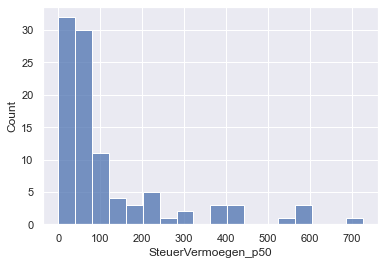

In [23]:
import seaborn as sns
sns.set(style="darkgrid")
sns.histplot(data=myGraph, x="SteuerVermoegen_p50") #, y="KonOGDKurz")
plt.show();

Test: Choroplethenkarte

**Test: Choroplethenkarte**
Importiere die Geodaten als GeoJSON

In [24]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
# Filepath statzonen
geojson_url = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Quartiere?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statistische_quartiere_map"
df_adm_statistische_quartiere_map = gpd.read_file(geojson_url)

df_adm_statistische_quartiere_map.head(5)


,id,kname,knr,objectid,objid,qname,qnr,geometry
0,adm_statistische_quartiere_map.1,Kreis 7,7,1,34,Hirslanden,73,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statistische_quartiere_map.2,Kreis 8,8,2,33,Weinegg,83,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ..."
2,adm_statistische_quartiere_map.3,Kreis 8,8,3,32,Mühlebach,82,"POLYGON ((8.55423 47.36456, 8.55426 47.36452, ..."
3,adm_statistische_quartiere_map.4,Kreis 8,8,4,31,Seefeld,81,"POLYGON ((8.54795 47.36500, 8.54805 47.36489, ..."
4,adm_statistische_quartiere_map.7,Kreis 4,4,7,16,Werd,41,"POLYGON ((8.53300 47.37394, 8.53299 47.37392, ..."


Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [25]:
selectMapAttr1 = data2betested[(data2betested.SteuerTarifLang=="Grundtarif") & (data2betested.SteuerJahr == "2018")]
selectMapAttr2 = data2betested[(data2betested.SteuerTarifLang=="Verheiratetentarif") & (data2betested.SteuerJahr == "2018")]


In [26]:
selectMapAttr1.head()


,SteuerJahr,QuarSort,QuarLang,SteuerTarifSort,SteuerTarifLang,SteuerVermoegen_p50,SteuerVermoegen_p25,SteuerVermoegen_p75
1938,2018-01-01,11,Rathaus,0,Grundtarif,48,2,290
1941,2018-01-01,12,Hochschulen,0,Grundtarif,55,5,311
1944,2018-01-01,13,Lindenhof,0,Grundtarif,79,5,398
1947,2018-01-01,14,City,0,Grundtarif,21,1,163
1950,2018-01-01,21,Wollishofen,0,Grundtarif,43,4,197


In [27]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name

stadtquartiere_shapes = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarSort'})

# Merge with `merge` method on shared variable (stznr und StatZoneSort):
stadtquartiere_shapes_joined = stadtquartiere_shapes.merge(selectMapAttr1, on='QuarSort')

stadtquartiere_shapes_joined.head(3)


,geometry,QuarSort,qname,knr,SteuerJahr,QuarLang,SteuerTarifSort,SteuerTarifLang,SteuerVermoegen_p50,SteuerVermoegen_p25,SteuerVermoegen_p75
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7,2018-01-01,Hirslanden,0,Grundtarif,66,10,308
1,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ...",83,Weinegg,8,2018-01-01,Weinegg,0,Grundtarif,60,6,293
2,"POLYGON ((8.55423 47.36456, 8.55426 47.36452, ...",82,Mühlebach,8,2018-01-01,Mühlebach,0,Grundtarif,67,7,300


<AxesSubplot:>

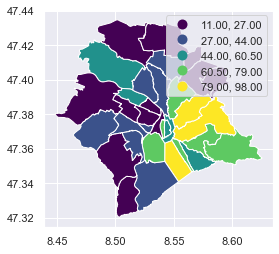

In [ ]:
# Plot by StatQuartiere

stadtquartiere_shapes_joined.plot(column='SteuerVermoegen_p50', cmap='viridis', scheme='natural_breaks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

stadtquartiere_shapes_joined.plot(column='SteuerVermoegen_p50', cmap='plasma', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html
stadtquartiere_shapes_joined.plot(column='SteuerVermoegen_p50', cmap='cool', scheme='fisherjenks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

stadtquartiere_shapes_joined.plot(column='SteuerVermoegen_p50', cmap='viridis', scheme='natural_breaks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

----------------------------------------------------------------------------------------

#Link https://automating-gis-processes.github.io/site/notebooks/L5/interactive-map-folium.html

# Create a Map instance
m = folium.Map(location=[60.25, 24.8], tiles = 'cartodbpositron', zoom_start=10, control_scale=True)

# Plot a choropleth map
# Notice: 'geoid' column that we created earlier needs to be assigned always as the first column
folium.Choropleth(
    geo_data=data,
    name='Population in 2018',
    data=data,
    columns=['geoid', 'pop18'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    line_color='white',
    line_weight=0,
    highlight=False,
    smooth_factor=1.0,
    #threshold_scale=[100, 250, 500, 1000, 2000],
    legend_name= 'Population in Helsinki').add_to(m)

#Show map
m

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html